Dataset Source: Al-Subaiey, A., Al-Thani, M., Alam, N. A., Antora, K. F., Khandakar, A., & Zaman, S. A. U. (2024, May 19). Novel Interpretable and Robust Web-based AI Platform for Phishing Email Detection. ArXiv.org. https://arxiv.org/abs/2405.11619*

In [1]:
import pandas as pd

data = pd.read_csv("datasets/CEAS_08.csv")
data["label"]
data["subject"]

0                                Never agree to be a loser
1                                   Befriend Jenna Jameson
2                                     CNN.com Daily Top 10
3        Re: svn commit: r619753 - in /spamassassin/tru...
4                               SpecialPricesPharmMoreinfo
                               ...                        
39149                          CNN Alerts: My Custom Alert
39150                          CNN Alerts: My Custom Alert
39151                                     Slideshow viewer
39152                                Note on 2-digit years
39153                        [Python-Dev] PEP 370 heads up
Name: subject, Length: 39154, dtype: object

In [9]:
sentences = list(map(lambda sentence: str(sentence), data["subject"].values))

In [10]:
s = set()
for sentence in sentences:
    for word in sentence.split():
        s.add(word)
num_unique_words = len(s)

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(sentences, data["label"], train_size=0.8, random_state=42)

In [16]:
import tensorflow as tf

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_unique_words, lower=True, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = tf.keras.preprocessing.sequence.pad_sequences(training_sequences, padding="post")

testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = tf.keras.preprocessing.sequence.pad_sequences(testing_sequences, padding="post")

In [28]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=num_unique_words, output_dim=128),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

history = model.fit(training_padded, y_train, epochs=7, validation_data=(testing_padded, y_test))

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, None, 128)         2891264   
                                                                 
 global_average_pooling1d_1  (None, 128)               0         
 0 (GlobalAveragePooling1D)                                      
                                                                 
 dense_20 (Dense)            (None, 32)                4128      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_21 (Dense)            (None, 1)                 33        
                                                                 
Total params: 2895425 (11.05 MB)
Trainable params: 2895425 (11.05 MB)
Non-trainable params: 0 (0.00 Byte)
_____________

In [39]:
import numpy as np

y_pred = model.predict(testing_padded)
y_pred = np.round(y_pred)

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print("Accuracy: ", accuracy_score(y_pred=y_pred, y_true=y_test))
print("Precision: ", precision_score(y_pred=y_pred, y_true=y_test))
print("Recall: ", recall_score(y_pred=y_pred, y_true=y_test))
print("F1 Score: ", f1_score(y_pred=y_pred, y_true=y_test))

245/245 [==============================] - 1s 3ms/step
Accuracy:  0.9873579364065892
Precision:  0.9869146005509641
Recall:  0.9903248099516241
F1 Score:  0.9886167644015177


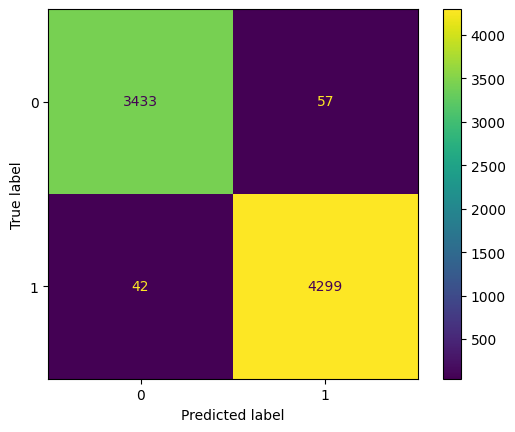

In [40]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cf_matrix = confusion_matrix(y_pred=y_pred, y_true=y_test)
ConfusionMatrixDisplay(cf_matrix).plot()